In [1]:
import sys
sys.path.append("../scripts/")
import warnings
from gridmap import *
from gridbase_pathplanning import*
from sensor import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [2]:
class DstarLite(GridBasePathPlanning):
    def __init__(
        self, world, sensor, grid_size_ratio=1,
        drawCost_flag=False, drawTakenPath_flag=True, drawPathToTake_flag=True, drawLocalMap_flag=False, drawMetricMap_flag=False, cost_adj=13
    ):
        super().__init__(world, grid_size_ratio)
        
        self.sensor = sensor
        self.local_map = np.full(self.world.grid_map.shape, -1, dtype=float)
        
        self.drawCost_flag = drawCost_flag
        self.drawPathToTake_flag = drawPathToTake_flag
        self.drawLocalMap_flag = drawLocalMap_flag
        self.drawMetricMap_flag = drawMetricMap_flag
        self.drawTakenPath_flag = drawTakenPath_flag
        self.cost_adj = cost_adj
        
        self.pp_algorithm_name = "DstarLite"
        
    def initialize(self):
        self.local_map = np.full(self.world.grid_map.shape, -1, dtype=np.int8)    #センシングによって構築したマップ
        self.local_map[self.world.start_index[0]][self.world.start_index[1]] = 0
        self.metric_grid_map = np.full(self.grid_cost_num, -1, dtype=float)    #経路計画で使用するマップ
        
        self.g_map = np.full(self.metric_grid_map.shape, float('inf'))
        self.rhs_map = np.full(self.metric_grid_map.shape, float('inf'))
        self.U = []
        self.km = 0.0
        
        for index, occupancy in np.ndenumerate(self.metric_grid_map):
            if self.hasGoal(index):
                self.rhs_map[index[0]][index[1]] = 0
                s_index = self.indexWorldToCost(self.world.start_index)
                self.uAppend(index, [self.h(s_index, index), 0])
            elif self.hasStart(index):
                self.metric_grid_map[index[0]][index[1]] = 0
                self.previousIndex = index
                self.currentIndex = np.array(index)
        
        self.pathToTake = []
        self.takenPath = []
        
        self.computeShortestPath(self.currentIndex)
    
    def draw(self, ax, elems):
        if self.g(self.currentIndex) == float('inf'):
            warnings.warn("Path does not exist")
            return
        
        # Check New Obstacle -> Move to Next Index
        self.checkNewObstacle(self.currentIndex)
        self.currentIndex = self.next(self.currentIndex)
        self.getPathToTake(self.currentIndex)
        self.takenPath.append(self.currentIndex)
        self.drawNewObstacles(ax, elems)
        self.drawLocalMap(ax, elems) if(self.drawLocalMap_flag) else None
        self.drawMetricMap(ax, elems) if(self.drawMetricMap_flag) else None
        self.drawPathToTake(ax, elems) if(self.drawPathToTake_flag) else None
        self.drawTakenPath(ax, elems) if(self.drawTakenPath_flag) else None
        self.drawRobot(ax, elems)
        self.drawCost(ax, elems, self.cost_adj) if(self.drawCost_flag) else None
    
    def run(self):
        self.initialize()
        while not self.hasGoal(self.currentIndex):
            if self.g(self.currentIndex) == float('inf'):
                warnings.warn("Dstar-Lite warning : Path does not find")
                break
            self.checkNewObstacle(self.currentIndex)
            self.currentIndex = self.next(self.currentIndex)
            self.takenPath.append(self.currentIndex)
            if np.count_nonzero(np.all(self.currentIndex == self.takenPath, axis=1)) > 10:
                warnings.warn("Dstar-Lite warning : Rover got stuck")
                break
    
    def plot(self, figsize=(4, 4), save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal
                self.world.drawGrid(index, "green", 1.0, ax)
        
        for index in self.takenPath:
            if (not self.hasStart(index)) and (not self.hasGoal(index)):
                self.drawCostSizeGrid(index, "red", 0.5, ax)
        
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def next(self, index):
        if self.hasGoal(index):
            return index
        min_cost = float('inf')
        next_index = index
        for grid in neigbor_grids:
            s_ = index + grid
            if self.isCostGridOutOfBounds(s_):
                continue
            if min_cost > self.c(index, s_) + self.rhs(s_):
                min_cost = self.c(index, s_) + self.g(s_)
                next_index = s_
        return next_index
            
    def checkNewObstacle(self, index):
        obstacles = self.sensor.sense(self.indexCostToWorld(index))
        self.newObstacles = []
        self.newObstaclesOnCost = []
        
        # 新たな障害物をリストアップ
        for u, occupancy in obstacles:
            if self.local_map[u[0]][u[1]] == -1.0:
                self.local_map[u[0]][u[1]] = occupancy
            else:
                if occupancy < 1 - 1e-10:
                    self.local_map[u[0]][u[1]] = updateP(self.local_map[u[0]][u[1]], occupancy)
            
            if self.local_map[u[0]][u[1]] > 0.3:
                u_metric = self.indexWorldToCost(u)
                self.newObstacles.append(u)
                if len(self.newObstaclesOnCost) == 0 or not np.any(np.all(u_metric == [obstacle for obstacle in self.newObstaclesOnCost], axis=1)):
                    self.newObstaclesOnCost.append(u_metric)
        
        # 障害物周囲の辺をリストアップ
        update_vertex_list = []
        for u in self.newObstaclesOnCost:
            for grid in neigbor_grids:
                v = u + grid
                update_vertex_list.append([u, v]) if not np.any([np.all(u == ver[0]) and np.all(v == ver[1]) for ver in update_vertex_list]) else None
                update_vertex_list.append([v, u]) if not np.any([np.all(v == ver[0]) and np.all(u == ver[1]) for ver in update_vertex_list]) else None
            for vertex in [[[-1, 0], [0, 1]], [[0, 1], [1, 0]], [[1, 0], [0, -1]], [[0, -1], [-1, 0]]]:
                w, x = u + np.array(vertex[0]), u + np.array(vertex[1])
                update_vertex_list.append([w, x]) if not np.any([np.all(w == ver[0]) and np.all(x == ver[1]) for ver in update_vertex_list]) else None
                update_vertex_list.append([x, w]) if not np.any([np.all(x == ver[0]) and np.all(w == ver[1]) for ver in update_vertex_list]) else None
        
        # コストが変わる辺をリストアップ
        updated_vertex = []
        for vertex in update_vertex_list:
            u, v = vertex[0], vertex[1]
            c = self.c(u, v)
            if c != float('inf'):
                updated_vertex.append([u, v, c, float('inf')])
        
        # Metric Mapを更新
        for u in self.newObstaclesOnCost:
            self.metric_grid_map[u[0]][u[1]] = 1
        
        # Rhsを更新
        for vertex in updated_vertex:
            u = vertex[0]
            v = vertex[1]
            c_old = vertex[2]
            c_new = vertex[3]
            if c_old > c_new:
                if not self.hasGoal(u):
                        self.rhs_map[u[0]][u[1]] = min(self.rhs(u), c_new + self.g(v))
            elif self.rhs(u) == c_old + self.g(v):
                if not self.hasGoal(u):
                    self.rhs_map[u[0]][u[1]] = self.getMinRhs(u)
            self.updateVertex(u)
        
        # 経路を再計算
        if len(updated_vertex) > 0:
            self.km = self.km + self.h(self.previousIndex, index)
            self.previousIndex = self.currentIndex
            self.computeShortestPath(index)
    
    def computeShortestPath(self, index):
        k_old = [0.0, 0.0]
        while k_old < self.calculateKey(index) or self.rhs(index) > self.g(index):
            U_row = [row[1] for row in self.U]
            u_data = min(U_row)
            idx = U_row.index(u_data)
            u, k_old = np.array(self.U[idx][0]), self.U[idx][1]
            k_new = self.calculateKey(u)
            g_u = self.g(u)
            rhs_u = self.rhs(u)
            
            if k_old < k_new:
                self.uUpdate(u, k_new)
            elif g_u > rhs_u:
                self.g_map[u[0]][u[1]] = rhs_u
                self.uRemove(u)
                for grid in neigbor_grids:
                    s = u + grid
                    if self.isCostGridOutOfBounds(s):
                        continue
                    if not self.hasGoal(s):
                        self.rhs_map[s[0]][s[1]] = min(self.rhs(s), self.c(s, u)+self.g(u))
                    self.updateVertex(s)
            else:
                g_old = self.g(u)
                self.g_map[u[0]][u[1]] = float('inf')
                for grid in neigbor_grids + [[0, 0]]:
                    s = u + grid
                    if self.isCostGridOutOfBounds(s):
                        continue
                    if self.rhs(s) == self.c(s, u) + g_old:
                        if not self.hasGoal(s):
                            self.rhs_map[s[0]][s[1]] = self.getMinRhs(s)
                    self.updateVertex(s)
    
    def getPathToTake(self, index):#今後の経路を描画
        self.pathToTake = [index]
        last_cost = float('inf')
        while not self.hasGoal(index):
            next_index = index
            min_cost = float('inf')
            for grid in neigbor_grids:
                s_ = index + grid
                if self.isCostGridOutOfBounds(s_) or np.any(np.all(self.pathToTake==s_, axis=1)):
                    continue
                if min_cost > self.c(index, s_) + self.rhs(s_) and last_cost >= self.rhs(s_):
                    min_cost = self.c(index, s_) + self.rhs(s_)
                    last_cost = self.rhs(s_)
                    next_index = s_
            index = next_index
            if np.any(np.all(self.pathToTake==index, axis=1)):
                break
            self.pathToTake.append(index)
    
    def calculateKey(self, s):
        return [min(self.g(s), self.rhs(s)) + self.h(self.indexWorldToCost(self.world.start_index), s) + self.km, min(self.g(s), self.rhs(s))]
    
    def updateVertex(self, u):
        u_flag = list(u) in [row[0] for row in self.U]
        g_u = self.g(u)
        rhs_u = self.rhs(u)
        if g_u != rhs_u and u_flag:
            self.uUpdate(u, self.calculateKey(u))
        elif g_u != rhs_u and not u_flag:
            self.uAppend(u, self.calculateKey(u))
        elif g_u == rhs_u and u_flag:
            self.uRemove(u)
    
    def uAppend(self, u, u_num):
        self.U.append([list(u), u_num])
    
    def uRemove(self, u):
        U_row = [row[0] for row in self.U]
        idx = U_row.index(list(u))
        self.U.remove([list(u), self.U[idx][1]])
    
    def uUpdate(self, u, u_num_new):
        U_row = [row[0] for row in self.U]
        idx = U_row.index(list(u))
        self.U[idx][1] = u_num_new
    
    def getMinRhs(self, u):
        min_rhs = float('inf')
        for grid in neigbor_grids:
            v = u + grid
            if self.isCostGridOutOfBounds(v):
                continue
            if min_rhs > self.c(u, v) + self.g(v):
                min_rhs = self.c(u, v) + self.g(v)
        return min_rhs
    
    def rhs(self, s):
        return self.rhs_map[s[0]][s[1]]
    
    def g(self, s):
        return self.g_map[s[0]][s[1]]
    
    def c(self, u, v): #隣接ノードへ移動するのに要するコスト
        if self.isCostGridOutOfBounds(u) or self.isObservedObstacle(u) or self.isCostGridOutOfBounds(v) or self.isObservedObstacle(v):
            return float('inf')
        else:
            if np.all(np.abs(u - v) == [1, 1]):
                c_ = 1.41
                if np.all(v - u == [1, 1]):
                    if self.metric_grid_map[u[0]+1][u[1]] == 1 or self.metric_grid_map[u[0]][u[1]+1] == 1:
                        c_ = float('inf')
                elif np.all(v - u == [1, -1]):
                    if self.metric_grid_map[u[0]+1][u[1]] == 1 or self.metric_grid_map[u[0]][u[1]-1] == 1:
                        c_ = float('inf')
                elif np.all(v - u == [-1, 1]):
                    if self.metric_grid_map[u[0]-1][u[1]] == 1 or self.metric_grid_map[u[0]][u[1]+1] == 1:
                        c_ = float('inf')
                elif np.all(v - u == [-1, -1]):
                    if self.metric_grid_map[u[0]-1][u[1]] == 1 or self.metric_grid_map[u[0]][u[1]-1] == 1:
                        c_ = float('inf')
            else:
                c_ = 1.0
            return c_

    def h(self, s1, s2):
        return 1.0 * np.linalg.norm(s1 - s2)
    
    def isU(self, u):
        U_row = [row[0] for row in self.U]
        return list(u) in U_row
    
    def isUnobserved(self, index):
        if self.metric_grid_map[index[0]][index[1]] == -1:
            return True
        else:
            return False
    
    def isObservedObstacle(self, index):
        #if self.metric_grid_map[index[0]][index[1]] == '0':
        if self.metric_grid_map[index[0]][index[1]] > 0.3:
            return True
        else:
            return False
    
    def drawNewObstacles(self, ax, elems):
        for index in self.newObstacles:
            if not(self.world.isStart(index)) and not(self.world.isGoal(index)):
                self.world.drawGrid(index, occupancyToColor(self.local_map[index[0]][index[1]]), 1.0, ax, fill=True)
    
    def drawTakenPath(self, ax, elems):
        for index in self.takenPath:
            if not(self.hasStart(index)) and not(self.hasGoal(index)):
                self.drawCostSizeGrid(index, "magenta", 0.5, ax, elems=elems)
    
    def drawPathToTake(self, ax, elems):
        for n in self.pathToTake:
            if (not self.hasStart(n)) and (not self.hasGoal(n)):
                self.drawCostSizeGrid(n, "red", 0.5, ax, elems=elems)
    
    def drawCost(self, ax, elems, cost_adj):
        for index, _ in np.ndenumerate(self.metric_grid_map):
            if(self.rhs(index) < 100000):    #LOWER状態のセルを描画
                c_num = int(self.rhs(index)) #Black→Blue
                c_num = int(c_num * cost_adj)
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*16*16 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*4/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                fill = True
                alpha = 0.5
                c = '#' + format(int(c_num), 'x').zfill(6)
                self.drawCostSizeGrid(index, c, alpha, ax, fill, elems)
            else:    #RAISE状態のセルを描画
                #self.world.drawGrid(index, "red", 1.0, ax. True, elems)
                continue
                
    def drawRobot(self, ax, elems):
        if not(self.hasStart(self.currentIndex)) and not(self.hasGoal(self.currentIndex)):
            self.drawCostSizeGrid(self.currentIndex, "blue", 1.0, ax, elems=elems)
    
    def drawLocalMap(self, ax, elems):
        for index, grid in np.ndenumerate(self.local_map):
            if(grid == 0):
                continue
            elif(grid == -1):
                c = "lightgray"
            elif(grid == 1):
                c = "black"
            self.world.drawGrid(index, c, 1.0, ax, elems=elems)
        self.world.drawGrid(self.world.goal_index, "green", 1.0, ax, elems=elems)
    
    def drawMetricMap(self, ax, elems):
        for index, grid in np.ndenumerate(self.metric_grid_map):
            if(grid == 1):
                continue
            elif(grid == -1):
                c = "lightgray"
            elif(grid == 0):
                c = "black"
            self.drawCostSizeGrid(index, c, 1.0, ax, elems=elems)
        self.world.drawGrid(self.world.goal_index, "green", 1.0, ax, elems=elems)

[376 423] [27 61] True False


../scripts\sensor.py:80: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1-p))
../scripts\sensor.py:83: RuntimeWarning: divide by zero encountered in log
  return l + np.log(p/(1-p))


<IPython.core.display.Javascript object>


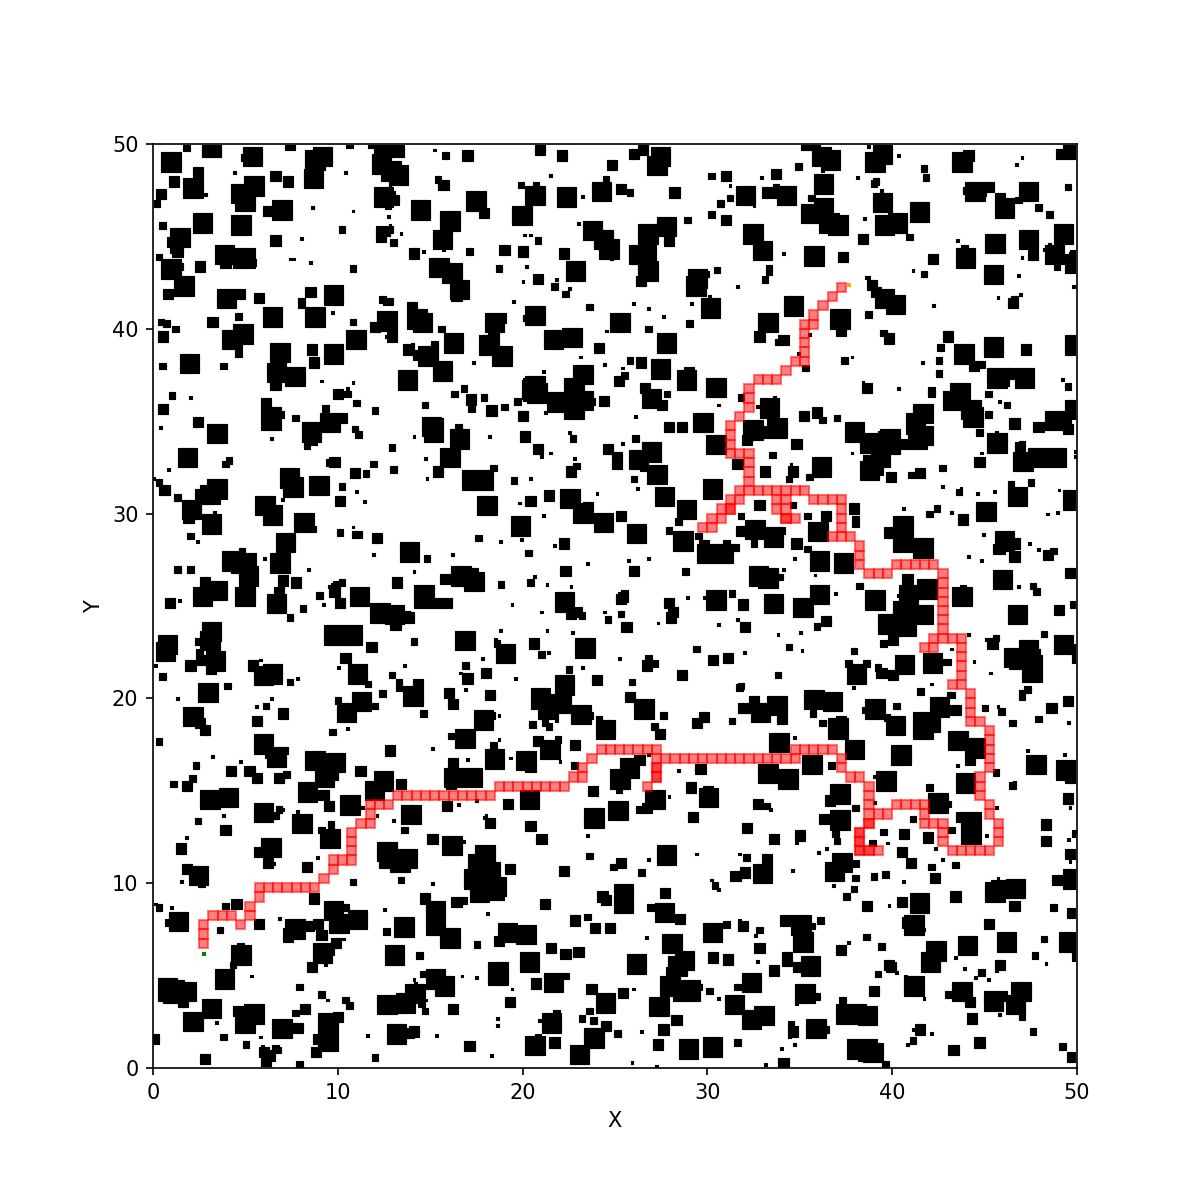

[68 44] [490 418] False True


<IPython.core.display.Javascript object>


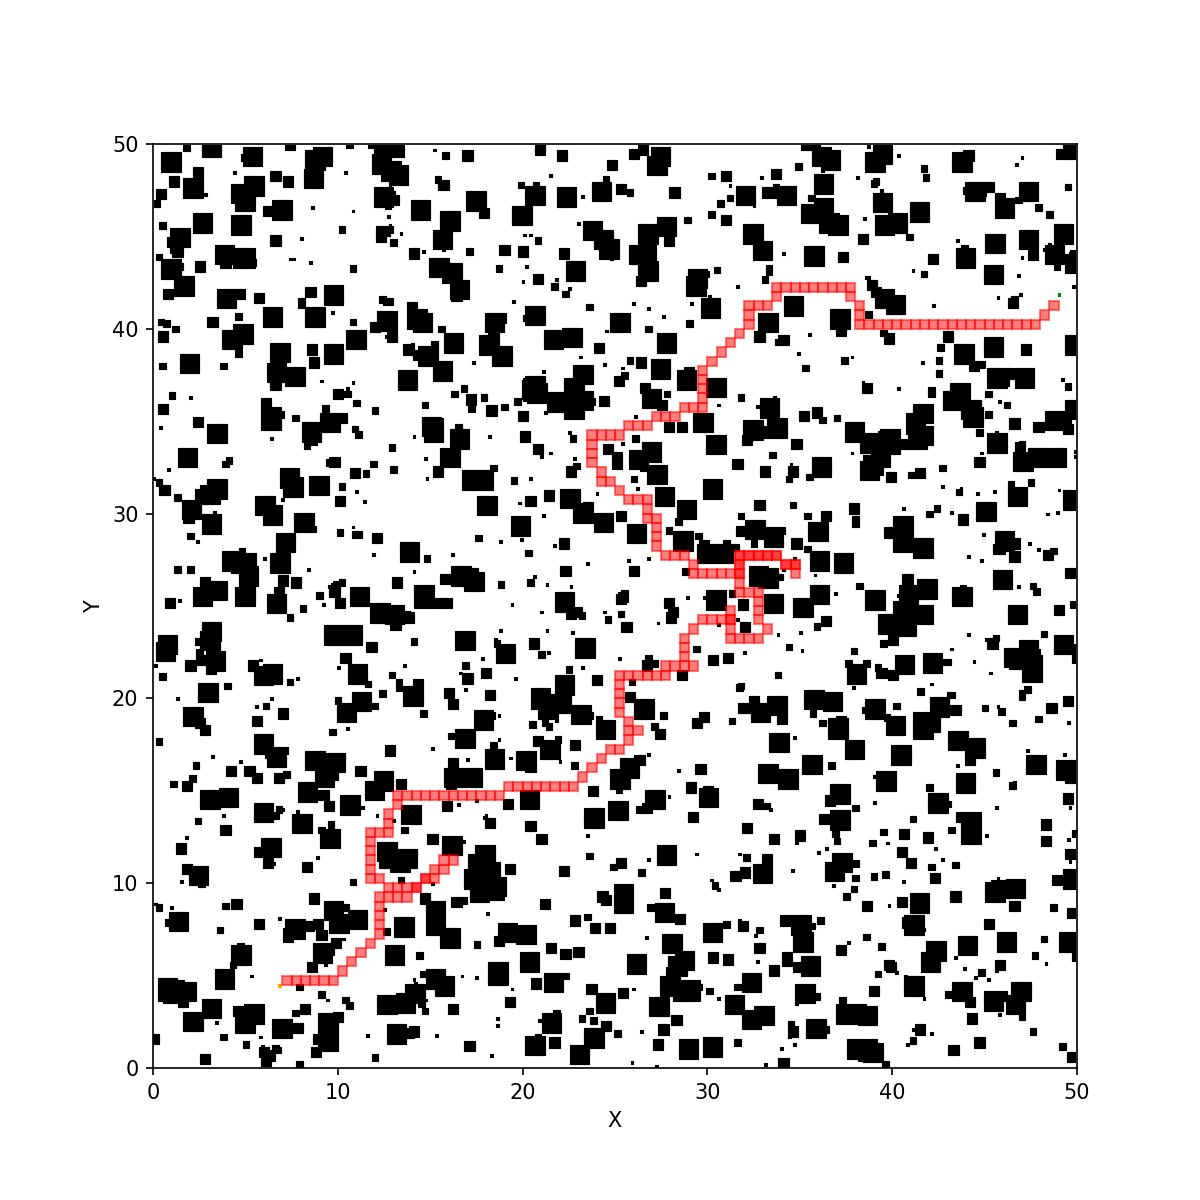

[472 398] [13 57] True True


<IPython.core.display.Javascript object>


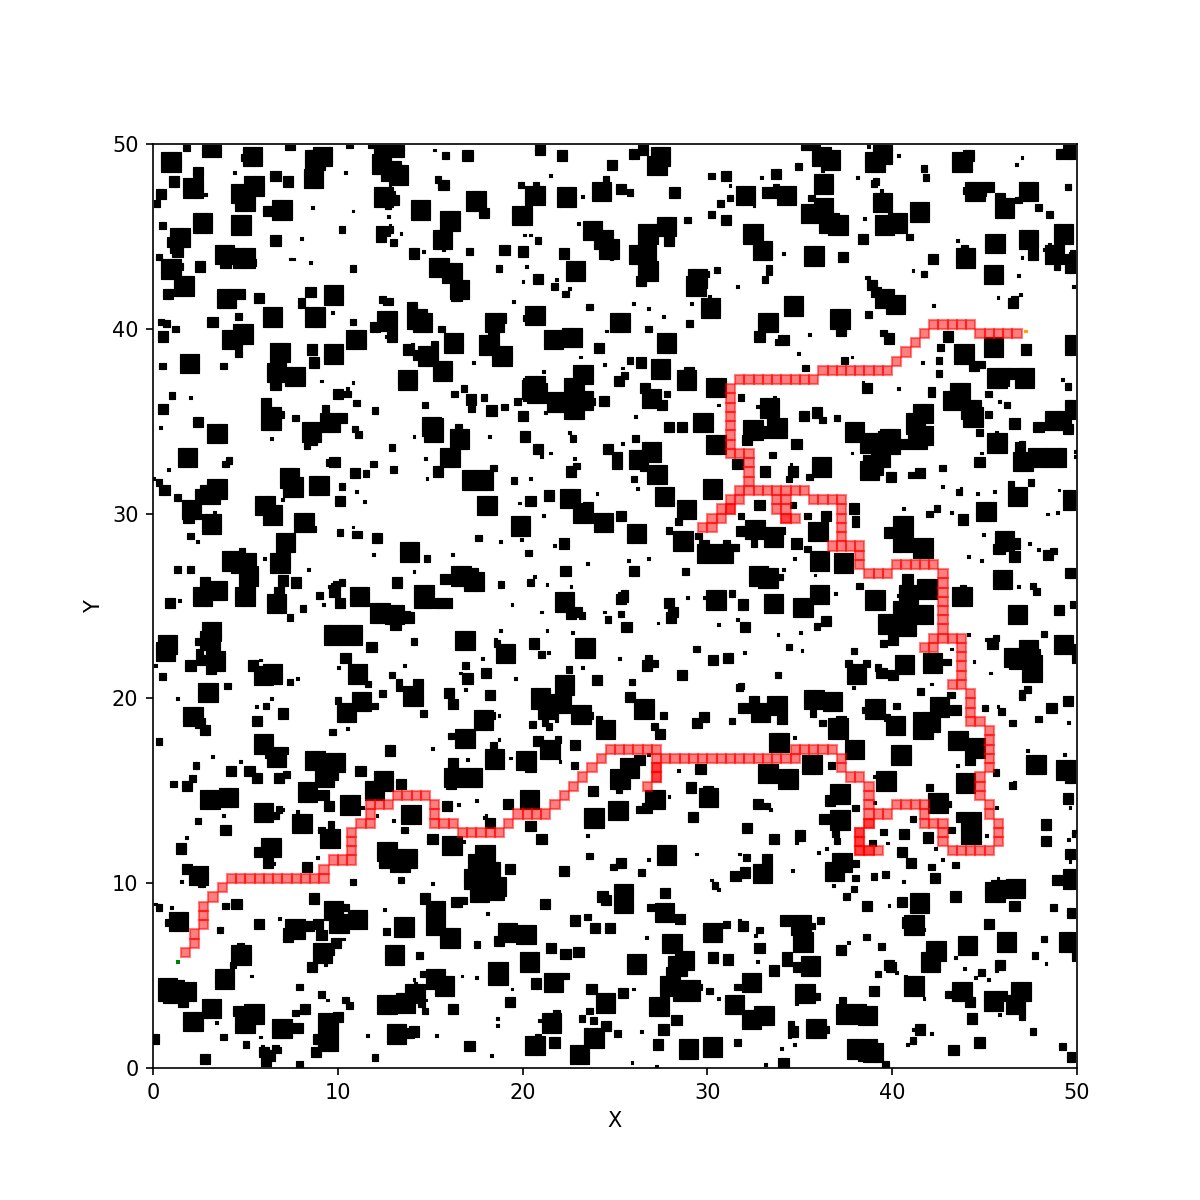

[  7 293] [488  46] True True


<IPython.core.display.Javascript object>


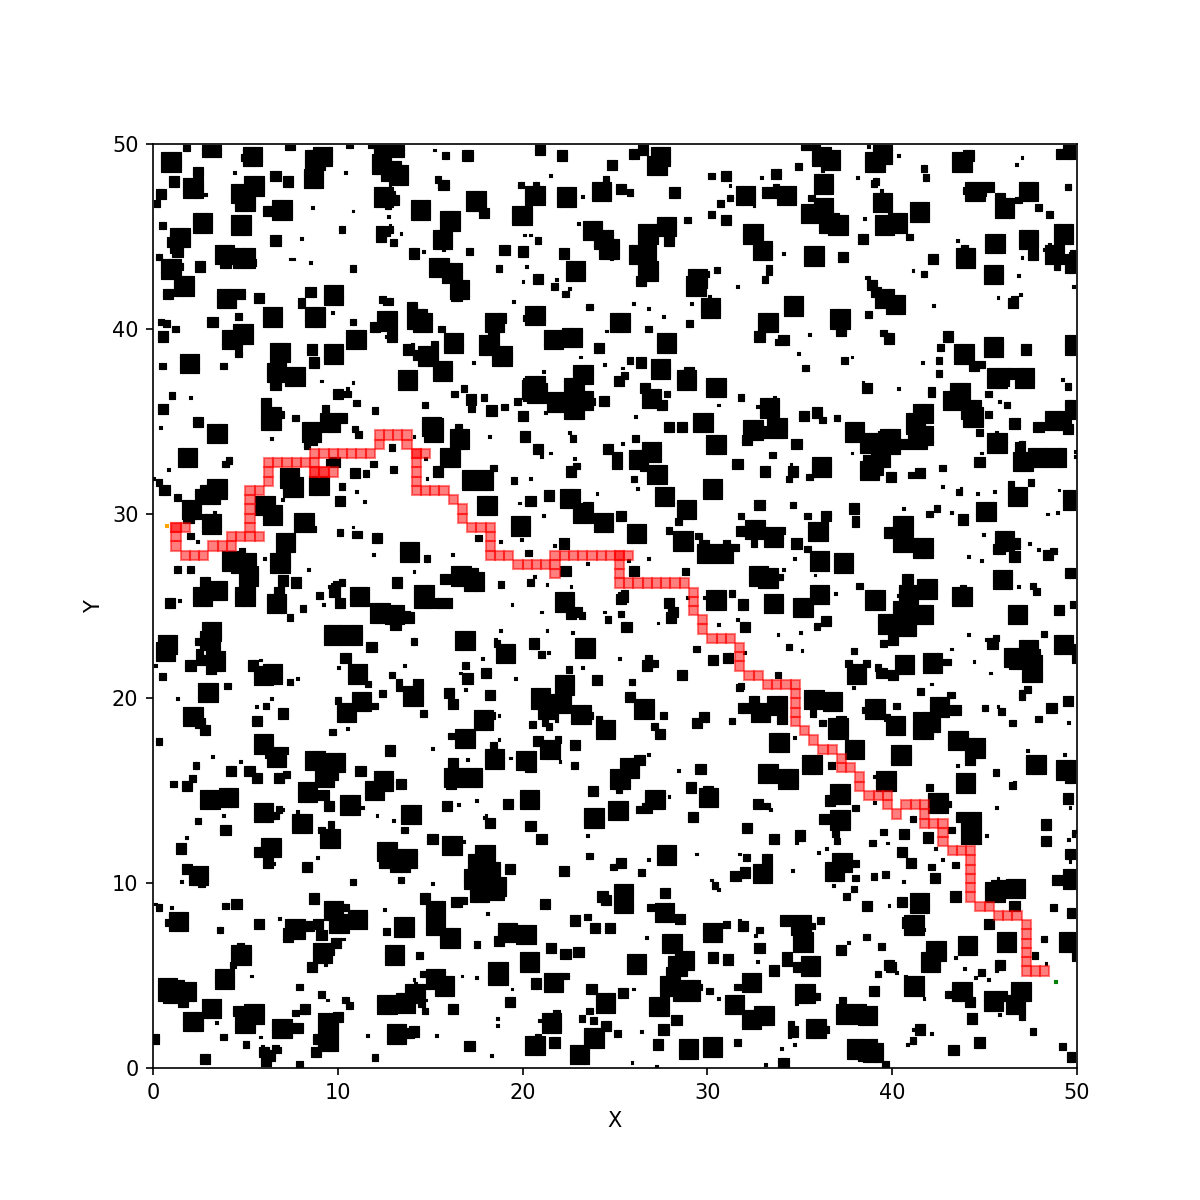

[478 424] [21 64] True True


<IPython.core.display.Javascript object>


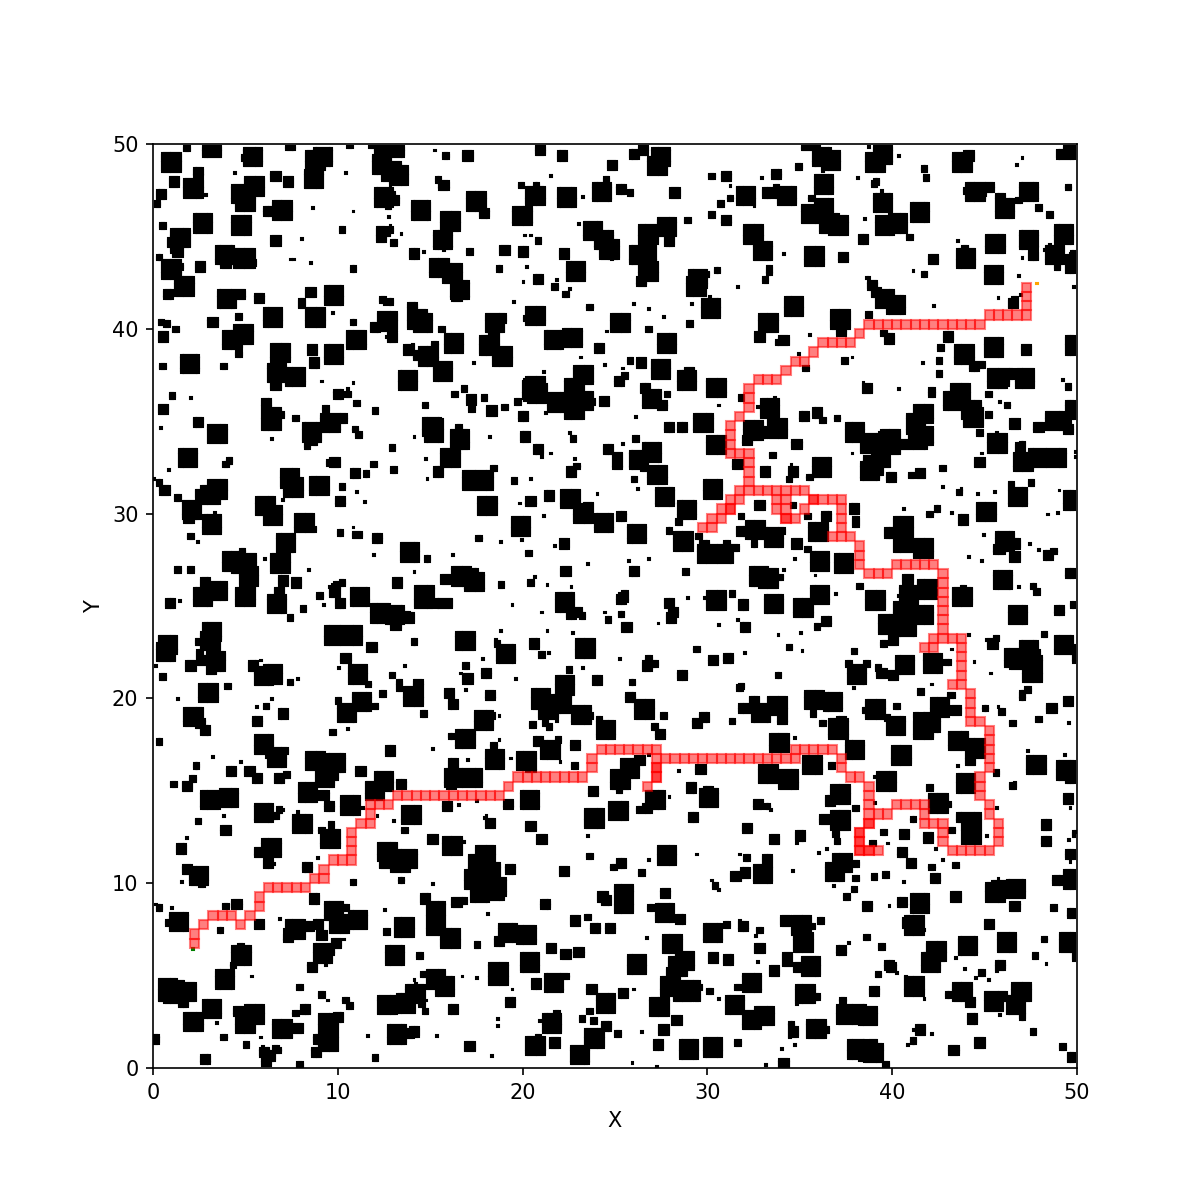

In [3]:
#if __name__ == "__main__":
time_span = 25
time_interval = 0.1

grid_step = np.array([0.1, 0.1])
grid_num = np.array([500, 500])
# grid_num = np.array([30, 30])

map_data = "../csvmap/map_20.csv"
# map_data = "../csvmap/map2.csv"

world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False, is_dynamic=True)
world.resetStartAndGoal(np.array([111, 49]), np.array([486, 474]), distance=500)
#print(world.start_index, world.goal_index)

cost_adj = 13   #map_2
#cost_adj = 16   #map_3
#cost_adj = 4    #map_large
sensor = IdealSensor(world, sensing_range=15)
pp = DstarLite(world, sensor, grid_size_ratio=5, cost_adj=5, drawCost_flag=False)
world.append(pp)

for i in range(5):
    world.resetStartAndGoal(gridsize=15, distance=500)
    print(world.start_index, world.goal_index, pp.hasObstacle(world.start_index), pp.hasObstacle(world.goal_index))
    pp.run()
    pp.plot(figsize=(8, 8))
# pp.initialize()
# world.draw(figsize=(8, 8))
# world.ani.save('dstarlite_map5.gif', writer='pillow', fps=100)    #アニメーション保存

In [4]:
print(pp.hasObstacle(world.start_index), pp.hasObstacle(world.goal_index))

True True
